In [68]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, Model, Input
import os
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [69]:
# Define dataset path
data_dir = "./data"

# tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Load dataset
batch_size = 256
img_size = (160, 160)
seed = 123


# The Data

The dataset used in this project is available at the following link:  
[Microsoft DigiFace-1M Dataset](https://github.com/microsoft/DigiFace1M)

> The DigiFace-1M dataset is a collection of over one million diverse synthetic face images for face recognition.  
> The DigiFace-1M dataset can be used for non-commercial research.  
>   
> The dataset contains:  
>   
> - 720K images with 10K identities (72 images per identity). For each identity, 4 different sets of accessories are sampled and 18 images are rendered for each set.  
> - 500K images with 100K identities (5 images per identity). For each identity, only one set of accessories is sampled.

From the dataset, I am using 32 folders, each representing a class of 3D-rendered synthetic people. Each folder includes 71 photos captured from different angles and lighting conditions.

## Batch Size

Batch size refers to the number of images processed by the model at once. In this case, 32 images are passed through the neural network per batch.

- **Larger Batch Size**: Speeds up training but requires more memory.
- **Smaller Batch Size**: Provides better generalization but slows down training.

I tried 32, 64 and 128 in my testing 128 seemed to preform best for me

## Image Size

Images are resized to 160x160 pixels before being fed into the neural network. This ensures that all input images have the same dimensions for consistency.

In [70]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int'
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int'
)


Found 7200 files belonging to 101 classes.
Using 5760 files for training.
Found 7200 files belonging to 101 classes.
Using 1440 files for validation.


In [71]:

# Rescaling and prefetching
normalisation_layer = tf.keras.layers.Rescaling(1./127.5, offset=-1)
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.map(lambda x, y: (normalisation_layer(x), y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: (normalisation_layer(x), y)).cache().prefetch(buffer_size=AUTOTUNE)


In [72]:
class_names = sorted(os.listdir(data_dir))
num_classes = len(class_names)
print("Classes:", class_names)
print("Total classes:", num_classes)

Classes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', 'me']
Total classes: 101


In [73]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [74]:
# Load base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Model definition
model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax', dtype='float32')
])

In [75]:

# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        mode='min',
        verbose=1
    ),
]


In [77]:
# Train the model with a large number of max epochs
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    batch_size=batch_size,
    callbacks=callbacks,
)


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - accuracy: 0.0128 - loss: 4.7328
Epoch 1: val_accuracy improved from -inf to 0.05833, saving model to model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.0132 - loss: 4.7280 - val_accuracy: 0.0583 - val_loss: 4.4584 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.0563 - loss: 4.4143
Epoch 2: val_accuracy improved from 0.05833 to 0.12847, saving model to model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 994ms/step - accuracy: 0.0567 - loss: 4.4111 - val_accuracy: 0.1285 - val_loss: 4.0755 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.1077 - loss: 4.0315
Epoch 3: val_accuracy improved from 0.12847 to 0.22917, saving model to model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 997ms/step - accuracy: 0.1084 - loss: 4.0271 - val_accuracy: 0.2292 - val_loss: 3.5470 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.1876

In [78]:
# Evaluating the model

test_loss, test_acc = model.evaluate(val_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 679ms/step - accuracy: 0.7737 - loss: 0.8374
Test Accuracy: 0.7799


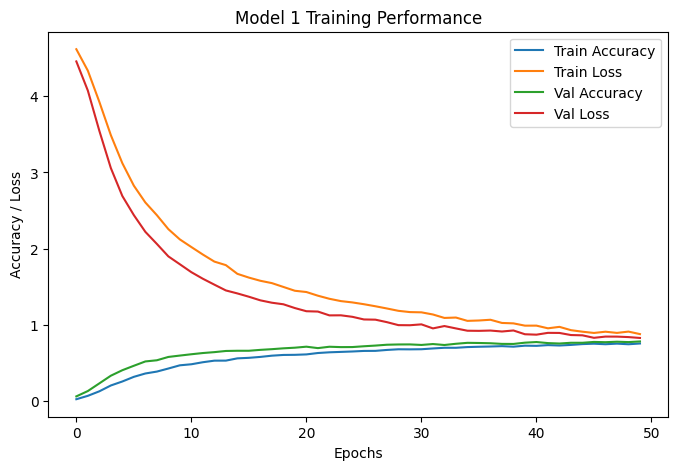

In [79]:
# Plotting the training performance
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.title('Model 1 Training Performance')
plt.show()
